In [14]:
import pickle as pkl

from scipy.special.cython_special import pdtrc

from epf.util import predict_with_timestamps

with open("../models/lstm_vre_sl.pkl", "rb") as f:
    model_obj = pkl.load(f)

lstm_preds, lstm_trues = predict_with_timestamps(model_obj)

In [15]:
min = model_obj['train_min']['de_prices_hat_rm_seasonal']
max = model_obj['train_max']['de_prices_hat_rm_seasonal']

In [16]:
# denormalize
lstm_preds = (lstm_preds - min) / (max - min)
lstm_trues = (lstm_trues - min) / (max - min)

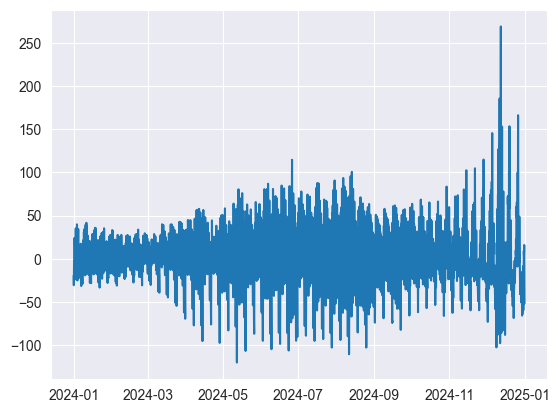

In [44]:
import pandas as pd

mstl = model_obj['seasonal']['de_prices_hat_rm_seasonal'].seasonal

horizons = range(1, 25)
col_names = [f't+{h}' for h in horizons]

seasonal_24 = pd.DataFrame(index=mstl.index, columns=col_names)
seasonal_168 = pd.DataFrame(index=mstl.index, columns=col_names)

# fill the naive predictions with the prices of the same hour from the previous week, each forecast is a row in the dataframe
for h in horizons:
    shift_amount = 24 - h  # 168 hours = 1 week
    seasonal_24[f't+{h}'] = mstl['seasonal_24'].shift(shift_amount)
    seasonal_168[f't+{h}'] = mstl['seasonal_168'].shift(shift_amount)

start = lstm_preds.index[0]
end = lstm_preds.index[-1]

#############################
periods = [24, 7*24]
real_values = model_obj['test_df']['de_prices_hat_rm_seasonal']
real_values = (real_values - min) / (max - min)
real_values = (real_values + sum(mstl[f'seasonal_{p}'] for p in periods))

import matplotlib.pyplot as plt
plt.plot(real_values)

real_values.index = real_values.index.tz_localize(None)
real_values = real_values.loc[start:end]
#############################

# remove the timezone awareness from the index
seasonal_24.index = seasonal_24.index.tz_localize(None)
seasonal_168.index = seasonal_24.index.tz_localize(None)
seasonal_24 = seasonal_24.loc[start:end]
seasonal_168 = seasonal_24.loc[start:end]

In [42]:
# deseasonalize
lstm_preds.columns = [col.replace('de_prices_hat_rm_seasonal_', '') for col in lstm_preds.columns]
lstm_trues.columns = [col.replace('de_prices_hat_rm_seasonal_', '') for col in lstm_trues.columns]

periods = [24, 7*24]

for col in lstm_preds.columns:
    lstm_preds[col] = (lstm_preds[col] + sum([seasonal_24[col], seasonal_168[col]]))

for col in lstm_trues.columns:
    lstm_trues[col] = (lstm_trues[col] + sum([seasonal_24[col], seasonal_168[col]]))

(np.float64(19936.0), np.float64(19966.0))

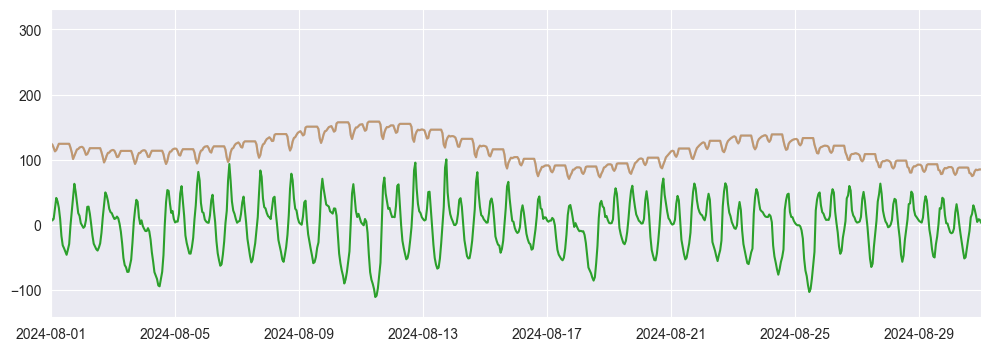

In [43]:
import matplotlib.pyplot as plt

plot_df_preds = lstm_preds.iloc[:, 1: ].mean(axis=1)
plot_df_trues = lstm_trues.iloc[:, 1: ].mean(axis=1)

start = pd.Timestamp('2024-08-01')
end = pd.Timestamp('2024-08-31')

plt.figure(figsize=(12, 4))
plt.plot(plot_df_preds, alpha=0.5)
plt.plot(plot_df_trues, alpha=0.5)
plt.plot(real_values)
plt.xlim(start, end)

In [41]:
real_values.describe().T

count    8731.000000
mean        0.085916
std        31.969962
min      -120.138347
25%       -17.245759
50%         0.641604
75%        18.433819
max       268.976863
dtype: float64